# 細胞アノテーション練習

https://labo-code.com/bioinformatics/scanpy-cell-annotation/

https://scanpy.readthedocs.io/en/stable/index.html

- 細胞アノテーションとは、細胞が発現しているRNA量（発現遺伝子）に基づき、細胞名を決定すること。これにより、試料の中にどんな細胞が存在していたかを同定することができる
- decoupler
クラスタリングしたあとのデータに対して、それぞれのクラスターの遺伝子の発現量とデータベースの細胞の発現量を比較。そこで統計的な検定を行い、データベースの中でもっとも類似した細胞タイプを割り当てる。次元削減によるクラスタリングに基づいているため、結果の解釈が容易。
参考：https://github.com/saezlab/decoupler-py/tree/main/decoupler
    - utils_anndataのrank_sources_groups関数
    - method_oraのora関数
- CellTypist
組織に局在する免疫細胞を解析するために作られたライブラリ。免疫細胞の細かいサブクラスまでアノテーションできる点が優れている。次元削減・クラスタリング前に行うため、これらの手法に依存せずにアノテーションできま、より客観的に細胞名を評価できる。
参考： C. Domínguez Conde et al. ,Cross-tissue immune cell analysis reveals tissue-specific features in humans.Science376,eabl5197(2022).DOI:10.1126/science.abl519
のSupplementary Materials p.27 Cell type prediction

In [1]:
data_dir = "data/filtered_gene_bc_matrices/hg19"

In [2]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io

import celltypist
from celltypist import models

import decoupler as dc

/home/omen/miniconda3/envs/env_py312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データ読み込み

In [3]:
barcodes_path = f'{data_dir}/barcodes.tsv'
genes_path = f'{data_dir}/genes.tsv'
matrix_path = f'{data_dir}/matrix.mtx'

In [4]:
# バーコード、特徴量、マトリックスの読み込み
barcodes = pd.read_csv(barcodes_path, header=None)
genes = pd.read_csv(genes_path, header=None, sep='\\t')
matrix = scipy.io.mmread(matrix_path)

/tmp/ipykernel_9162/757747128.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  genes = pd.read_csv(genes_path, header=None, sep='\\t')


In [5]:
# AnnDataオブジェクトの作成
adata = sc.AnnData(X=matrix.T.tocsr())
adata.obs_names = barcodes[0].values # 細胞名
adata.var_names = genes[1].values # 遺伝子名

## 前処理

In [6]:
# 遺伝子の重複を取り除く
new_data = adata.to_df()
new_data.describe()

,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10,...,KIR3DL2,AL590523.1,CT476828.1,PNRC2,SRSF10,AC145205.1,BAGE5,CU459201.1,AC002321.2,AC002321.1
count,2700.0,2700.0,2700.0,2700.0,2700.0,2700.000000,2700.0,2700.0,2700.000000,2700.0,...,2700.0,2700.0,2700.0,2700.000000,2700.000000,2700.0,2700.0,2700.0,2700.0,2700.0
mean,0.0,0.0,0.0,0.0,0.0,0.003333,0.0,0.0,0.001111,0.0,...,0.0,0.0,0.0,0.042963,0.025926,0.0,0.0,0.0,0.0,0.0
std,0.0,0.0,0.0,0.0,0.0,0.057649,0.0,0.0,0.033321,0.0,...,0.0,0.0,0.0,0.213491,0.161258,0.0,0.0,0.0,0.0,0.0
min,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
25%,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
50%,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
75%,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
max,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,1.000000,0.0,...,0.0,0.0,0.0,2.000000,2.000000,0.0,0.0,0.0,0.0,0.0


In [7]:
new_data.head()

,MIR1302-10,FAM138A,OR4F5,RP11-34P13.7,RP11-34P13.8,AL627309.1,RP11-34P13.14,RP11-34P13.9,AP006222.2,RP4-669L17.10,...,KIR3DL2,AL590523.1,CT476828.1,PNRC2,SRSF10,AC145205.1,BAGE5,CU459201.1,AC002321.2,AC002321.1
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
new_data = new_data.groupby(new_data.columns, axis=1).sum()
new_data.head()

,5S_rRNA,7SK,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2ML1-AS1,A2ML1-AS2,...,ZZEF1,ZZZ3,hsa-mir-1199,hsa-mir-1253,hsa-mir-150,hsa-mir-335,hsa-mir-490,hsa-mir-7515,hsa-mir-8072,snoU13
AAACATACAACCAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGAGCTAC-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACATTGATCAGC-1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGCTTCCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AAACCGTGTATGCG-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
adata = sc.AnnData(X=new_data.values)
# AnnDataについて細胞名(.obs_names)と遺伝子名(.var_names)を設定
adata.obs_names = new_data.index
adata.var_names = new_data.columns
print(adata.obs_names, adata.var_names)

Index(['AAACATACAACCAC-1', 'AAACATTGAGCTAC-1', 'AAACATTGATCAGC-1',
       'AAACCGTGCTTCCG-1', 'AAACCGTGTATGCG-1', 'AAACGCACTGGTAC-1',
       'AAACGCTGACCAGT-1', 'AAACGCTGGTTCTT-1', 'AAACGCTGTAGCCA-1',
       'AAACGCTGTTTCTG-1',
       ...
       'TTTCAGTGTCACGA-1', 'TTTCAGTGTCTATC-1', 'TTTCAGTGTGCAGT-1',
       'TTTCCAGAGGTGAG-1', 'TTTCGAACACCTGA-1', 'TTTCGAACTCTCAT-1',
       'TTTCTACTGAGGCA-1', 'TTTCTACTTCCTCG-1', 'TTTGCATGAGAGGC-1',
       'TTTGCATGCCTCAC-1'],
      dtype='object', length=2700) Index(['5S_rRNA', '7SK', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1',
       'A2ML1-AS1', 'A2ML1-AS2',
       ...
       'ZZEF1', 'ZZZ3', 'hsa-mir-1199', 'hsa-mir-1253', 'hsa-mir-150',
       'hsa-mir-335', 'hsa-mir-490', 'hsa-mir-7515', 'hsa-mir-8072', 'snoU13'],
      dtype='object', length=32643)


In [10]:
# QC情報をadata.obsに追加
def QC(adata):
    mt_gene_mask = [gene for gene in adata.var_names if gene.startswith("MT-")]
    percent_mt = adata[:,mt_gene_mask].X.sum(axis=1) / adata.X.sum(axis=1) * 100
    nFeature_RNA = (adata.X > 0).sum(axis=1)
    nCount_RNA = adata.X.sum(axis=1)

    # `adata.obs` に追加
    adata.obs["nFeature_RNA"] = nFeature_RNA
    adata.obs["nCountRNA"] = nCount_RNA
    adata.obs["percent_mt"] = percent_mt

QC(adata)

In [11]:
print(adata.obs)

                  nFeature_RNA  nCountRNA  percent_mt
AAACATACAACCAC-1           781     2421.0    3.015283
AAACATTGAGCTAC-1          1352     4903.0    3.793596
AAACATTGATCAGC-1          1131     3149.0    0.889171
AAACCGTGCTTCCG-1           960     2639.0    1.743085
AAACCGTGTATGCG-1           522      981.0    1.223242
...                        ...        ...         ...
TTTCGAACTCTCAT-1          1155     3461.0    2.109217
TTTCTACTGAGGCA-1          1227     3447.0    0.928343
TTTCTACTTCCTCG-1           622     1684.0    2.197150
TTTGCATGAGAGGC-1           454     1024.0    2.050781
TTTGCATGCCTCAC-1           724     1985.0    0.806045

[2700 rows x 3 columns]


In [12]:
# QCフィルタを適用してadata_QCを作成
adata_QC = adata[
    (adata.obs['nFeature_RNA'] > 200) &
    (adata.obs['nFeature_RNA'] < 5000) &
    (adata.obs['nCountRNA'] > 500) &
    (adata.obs['percent_mt'] < 10)
].copy()
adata_QC

AnnData object with n_obs × n_vars = 2694 × 32643
    obs: 'nFeature_RNA', 'nCountRNA', 'percent_mt'

## 可視化

In [24]:
violin_adata = sc.AnnData(adata_QC)
violin_adata

AnnData object with n_obs × n_vars = 2694 × 32643
    obs: 'nFeature_RNA', 'nCountRNA', 'percent_mt'

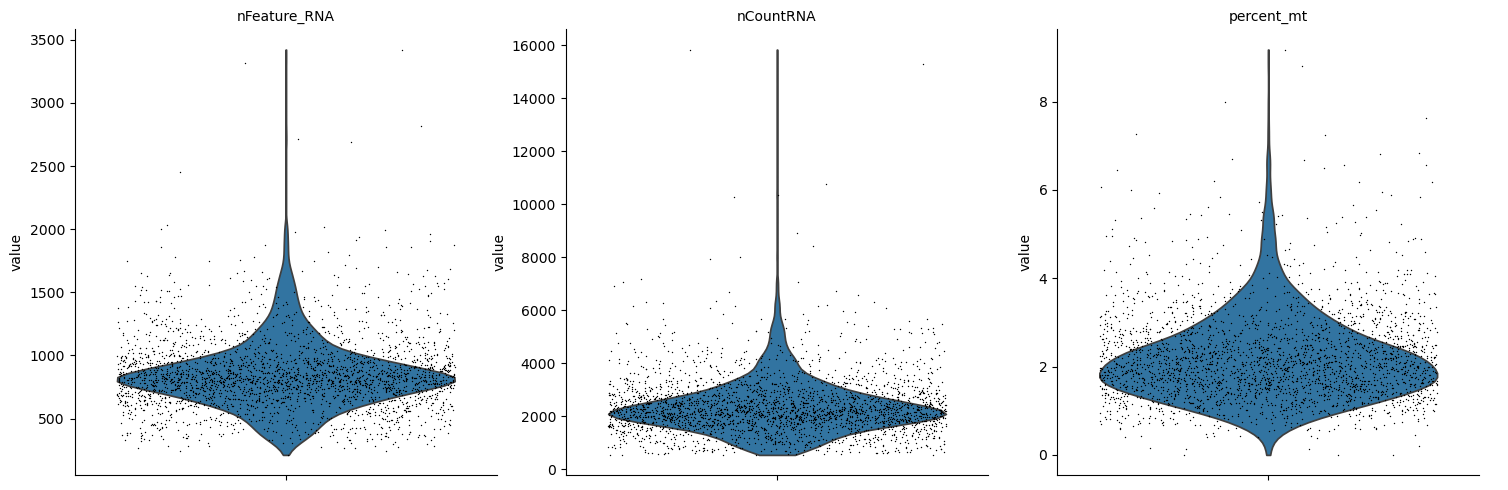

In [14]:
# バイオリンプロット
sc.pl.violin(violin_adata, keys=["nFeature_RNA", "nCountRNA", "percent_mt"], jitter=0.4, multi_panel=True)

In [22]:
df_violin_QC = pd.DataFrame({
    "nFeature_RNA": adata_QC.obs["nFeature_RNA"], 
    "nCount_RNA": adata_QC.obs["nCountRNA"], 
    "percent_mt": adata_QC.obs["percent_mt"]
    }, index = adata.obs_names
)
df_violin_QC

,nFeature_RNA,nCount_RNA,percent_mt
AAACATACAACCAC-1,781.0,2421.0,3.015283
AAACATTGAGCTAC-1,1352.0,4903.0,3.793596
AAACATTGATCAGC-1,1131.0,3149.0,0.889171
AAACCGTGCTTCCG-1,960.0,2639.0,1.743085
AAACCGTGTATGCG-1,522.0,981.0,1.223242
...,...,...,...
TTTCGAACTCTCAT-1,1155.0,3461.0,2.109217
TTTCTACTGAGGCA-1,1227.0,3447.0,0.928343
TTTCTACTTCCTCG-1,622.0,1684.0,2.197150
TTTGCATGAGAGGC-1,454.0,1024.0,2.050781


In [26]:
# 散布図
corr_nCount_percent_mt = np.corrcoef(df_violin_QC['nCount_RNA'], df_violin_QC['percent_mt'])[0,1]
corr_nCount_nFeature_RNA = np.corrcoef(df_violin_QC['nCount_RNA'], df_violin_QC['nFeature_RNA'])[0,1]

sc.pl.scatter(violin_adata, x=violin_adata.obs['nCountRNA'], y=violin_adata.obs['percent_mt'], title=f'nCount_RNA vs percent_mt(corr:{corr_nCount_percent_mt:.2f})')
sc.pl.scatter(violin_adata, x='nCount_RNA', y='nFeature_RNA', title = f'nCount_RNA vs nFeature_RNA(corr:{corr_nCount_nFeature_RNA:.2f})')

ValueError: `x`, `y`, and potential `color` inputs must all come from either `.obs` or `.var`

## 前処理 正規化

- adata_QC は anndata.AnnData オブジェクト。これは、遺伝子発現データとメタデータを一緒に格納するデータ構造。
- anndata の X 属性には、遺伝子発現データの行列 (遺伝子 × 細胞) が格納される。
- adata.var (遺伝子情報) や adata.obs (細胞情報) も保持できる。

In [ ]:
print(adata_QC)
print(adata_QC.X)
print(adata_QC.var)

AnnData object with n_obs × n_vars = 2694 × 32643
    obs: 'nFeature_RNA', 'nCountRNA', 'percent_mt'
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Empty DataFrame
Columns: []
Index: [5S_rRNA, 7SK, A1BG, A1BG-AS1, A1CF, A2M, A2M-AS1, A2ML1, A2ML1-AS1, A2ML1-AS2, A3GALT2, A4GALT, A4GNT, AAAS, AACS, AADAC, AADACL2, AADACL3, AADACL4, AADAT, AAED1, AAGAB, AAK1, AAMDC, AAMP, AANAT, AAR2, AARD, AARS, AARS2, AARSD1, AASDH, AASDHPPT, AASS, AATF, AATK, AATK-AS1, AB019440.50, ABAT, ABCA1, ABCA10, ABCA12, ABCA13, ABCA2, ABCA3, ABCA4, ABCA5, ABCA6, ABCA7, ABCA8, ABCA9, ABCA9-AS1, ABCB1, ABCB10, ABCB11, ABCB4, ABCB5, ABCB6, ABCB7, ABCB8, ABCB9, ABCC1, ABCC10, ABCC11, ABCC12, ABCC2, ABCC3, ABCC4, ABCC5, ABCC5-AS1, ABCC6, ABCC8, ABCC9, ABCD1, ABCD2, ABCD3, ABCD4, ABCE1, ABCF1, ABCF2, ABCF3, ABCG1, ABCG2, ABCG4, ABCG5, ABCG8, ABHD1, ABHD10, ABHD11, ABHD12, ABHD12B, ABHD13, ABHD14A, ABHD14A-ACY1

In [ ]:
# 正規化
# 各細胞ごとの総発現量を10000にスケールし細胞ごとの発現量のスケールの違いを補正
# そのあと、自然対数変換を行う
sc.pp.normalize_total(adata_QC, target_sum=1e4)
sc.pp.log1p(adata_QC) # log1pで変換されていることが前提

In [ ]:
from scipy.stats import sigmaclip
from statsmodels.nonparametric.smoothers_lowess import lowess

In [ ]:
# 遺伝子発現データ (行: 遺伝子, 列: 細胞)
expression_data = pd.DataFrame(adata_QC.X.toarray() if hasattr(adata_QC.X, "toarray") else adata_QC.X)
expression_data.head()

,0,1,2,3,4,5,6,7,8,9,...,32633,32634,32635,32636,32637,32638,32639,32640,32641,32642
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.429261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# 遺伝子発現データの平均発現量と分散を計算
gene_means = expression_data.mean(axis=1)
gene_vars = expression_data.var(axis=1)

# ログ変換
log_gene_means = np.log1p(gene_means)
log_gene_vars = np.log1p(gene_vars)

# Loess回帰で分散をスムージング
# 遺伝子ごとの 平均発現量 (log-transformed) を x 軸、分散を y 軸、Loess 回帰でスムージングして、期待される分散 を推定
fitted_vars = lowess(log_gene_vars, log_gene_means, frac=0.3, return_sorted=False)

# 標準化した分散
gene_dispersion = log_gene_vars - fitted_vars
gene_dispersion

0      -0.002591
1      -0.010761
2      -0.001426
3       0.001181
4       0.003096
          ...   
2689   -0.000100
2690    0.001679
2691    0.001022
2692   -0.000172
2693    0.000137
Length: 2694, dtype: float64

In [ ]:
# 上位2000の遺伝子を選択
top_genes = gene_dispersion.nlargest(2000).index
top_genes

Index([ 216,  729, 2232, 1961, 2197, 2644, 2449, 2274, 1775, 1512,
       ...
       1506, 1463, 1447, 1062, 2604,  300,   26,  713, 1266, 1770],
      dtype='int64', length=2000)

In [ ]:
print(adata_QC.var.index[:10])  # 最初の10個のインデックスを表示
print(adata_QC.var_names[:10])  # 最初の10個の要素を表示
print(adata_QC.var.columns)
print(top_genes[:10])  # `top_genes` の最初の10個の値を表示

Index(['5S_rRNA', '7SK', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1',
       'A2ML1-AS1', 'A2ML1-AS2'],
      dtype='object')
Index(['5S_rRNA', '7SK', 'A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A2ML1',
       'A2ML1-AS1', 'A2ML1-AS2'],
      dtype='object')
Index([], dtype='object')
Index([216, 729, 2232, 1961, 2197, 2644, 2449, 2274, 1775, 1512], dtype='int64')


In [ ]:
top_gene_names = adata_QC.var.index[top_genes]  # インデックスから遺伝子名に変換
# マスクを作成し、adataに格納
adata_QC.var['highly_variable'] = False
adata_QC.var.loc[top_gene_names, 'highly_variable'] = True

In [ ]:
# 高可変性遺伝子のみを抽出
highly_variable_mask = adata_QC.var['highly_variable']
adata_highly_variable = adata_QC[:, highly_variable_mask].copy()

## CellTypist：各細胞の遺伝子発現プロファイルをもとに、細胞タイプを予測・注釈付けするツール

1. 高次元データの次元削減 (PCAやUMAP)  
scRNA-seq のデータは、数千～数万の遺伝子発現データ を含む高次元データ。
高次元データはそのままでは解析しづらいため、次元削減によりデータの要約を行う。
PCA (主成分分析)：  
高次元データを線形的に要約し、情報の多い軸を抽出。
主に計算効率を向上させ、ノイズを削減するために使用。
UMAP (Uniform Manifold Approximation and Projection)：  
高次元データを非線形的に2次元または3次元に縮約。
細胞間の類似性 を空間的に表現し、細胞群の視覚的なパターンを明らかにする。
2. 隣接グラフの構築 (Neighbor Graph)  
次元削減後、細胞間の類似性を定量化するために、隣接グラフ (Neighbor Graph) を作成する。
これにより、各細胞が他の細胞とどれだけ似ているかを数値的に表現できる。
隣接グラフは、UMAPやクラスタリングに必要。
3. クラスタリング  
隣接グラフを基に、似ている細胞をまとめてクラスタを作成する。
クラスタリング手法：  
Leidenアルゴリズム：隣接グラフを基に、細胞をコミュニティ（クラスタ）に分ける。
クラスタは、未知の細胞群やサブタイプの発見に役立つ。
クラスタリングの結果を CellTypist に渡すことで、細胞群ごとの細胞種予測 を行う。
4. 可視化 (UMAPプロット)  
次元削減した結果を可視化し、クラスタリングされた細胞の空間的パターンを確認。
UMAPプロット：  
細胞間の類似性を2次元空間に投影。
クラスタごとの空間的な分布を視覚的に把握可能。

In [ ]:
# スケーリング前のデータを保存
adata_QC.layers['before_DimRed'] = adata_QC.X.copy()
adata_QC[:, highly_variable_mask].X = adata_highly_variable.X

In [ ]:
# PCAの実行
sc.tl.pca(adata_QC, svd_solver='arpack')# 上位20～50の主成分を使用して、データを要約

In [ ]:
# 主成分空間の座標
adata_QC.obsm['X_pca']

array([[-1.4513196 ,  0.22285046, -0.16802663, ..., -0.05823983,
        -1.5432825 , -1.1407624 ],
       [-0.03123421, -0.41206437,  0.28283858, ...,  1.2612112 ,
        -0.53172874, -0.06065779],
       [-0.8002812 ,  1.1569825 ,  0.28784123, ..., -0.18786916,
        -0.05179536,  1.0313182 ],
       ...,
       [-2.2088356 ,  0.26553562,  0.04132763, ...,  0.20545335,
        -0.3893693 , -0.03325425],
       [-2.097649  ,  0.40380576, -0.03012412, ...,  0.7630033 ,
        -0.2829024 , -2.1824305 ],
       [-0.2557351 , -0.02206545, -0.21997268, ..., -0.34438512,
        -0.49959642, -0.11585341]], dtype=float32)

In [ ]:
# 隣接グラフの構築
sc.pp.neighbors(adata_QC, n_pcs=20) # 上位20個の主成分を使用

In [ ]:
# UMAPの実行（データを2次元空間に投影し、類似性を視覚化）
sc.tl.umap(adata_QC)

In [ ]:
adata_QC.obsm['X_umap']

array([[ 2.0240283, -9.066188 ],
       [ 1.4357418, -4.6484513],
       [ 1.6247544, -5.0542026],
       ...,
       [ 2.3515832, -8.955541 ],
       [ 1.2294579, -9.832446 ],
       [ 3.559997 , -7.1217613]], dtype=float32)

In [ ]:
# 隣接グラフの構築
sc.pp.neighbors(adata_QC, n_pcs=10) # 上位10個の主成分を使用

In [ ]:
# クラスタリング
sc.tl.leiden(adata_QC, resolution=0.5) # クラスタの解像度を resolution=0.5 で指定

In [ ]:
# 各細胞がどのクラスタに属するかを記録
adata_QC.obs['leiden']

AAACATACAACCAC-1    0
AAACATTGAGCTAC-1    1
AAACATTGATCAGC-1    1
AAACCGTGCTTCCG-1    2
AAACCGTGTATGCG-1    1
                   ..
TTTCGAACTCTCAT-1    2
TTTCTACTGAGGCA-1    1
TTTCTACTTCCTCG-1    0
TTTGCATGAGAGGC-1    0
TTTGCATGCCTCAC-1    0
Name: leiden, Length: 2694, dtype: category
Categories (8, object): ['0', '1', '2', '3', '4', '5', '6', '7']

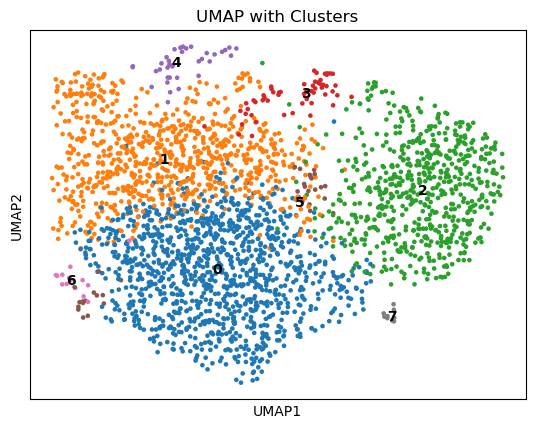

In [ ]:
# UMAPプロットの作成
sc.pl.umap(adata_QC, color='leiden', legend_loc='on data', title='UMAP with Clusters')

In [ ]:
# decouplerはクラスタリングの後のデータを用いるのでここで保存する
adata_clusterd = adata_QC.copy()

## decouplerのアノテーション

In [ ]:
adata_decoupler = adata_clusterd.copy()
markers = dc.get_resource('PanglaoDB')

56.5kB [00:00, 165MB/s]
5.91MB [00:01, 3.29MB/s]


In [ ]:
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]

- Over-Representation Analysis (ORA)   
特定の遺伝子セット (Pathways, GO terms) が 統計的に過剰に含まれているか を評価する手法

In [ ]:
# Over-Representation Analysisを実行
dc.run_ora(mat=adata_decoupler, net=markers, source='cell_type', target='genesymbol', min_n=3, verbose=True, use_raw=False)
# ORAのスコアを保存
acts = dc.get_acts(adata_decoupler, obsm_key='ora_estimate')
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

16028 features of mat are empty, they will be removed.
Running ora on mat with 2694 samples and 16615 targets for 164 sources.


100%|██████████| 2694/2694 [00:01<00:00, 1454.04it/s]


In [ ]:
# ORAスコアをもとにクラスターごとに細胞タイプのランキングを作る
df_decoupler = dc.rank_sources_groups(acts, groupby='leiden', reference='rest', method='t-test_overestim_var')

# ランキング一位の細胞タイプを取り出す
annotation_dict = df_decoupler.groupby('group').head(1).set_index('group')['names'].to_dict()

NameError: name 'dc' is not defined